In [1]:
from pydrake.all import StartMeshcat, MeshcatVisualizer, AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams, ConstantValueSource, LogVectorOutput
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import DiagramBuilder, Simulator, Parser
from direct_col_dev import find_throwing_trajectory
from phase_switch import *
from osc import *
import pydot

### Parameters ###
file_name = "/home/dhruv/Hop-Skip-and-Jump/models/planar_walker.urdf"

# DIRCOL Parameters #
N = 10
jump_height = 0.5
tf = 1/2

# Robot Parameters #
initial_state = np.zeros(14)
q = np.zeros((7,))
q[0] = 0; q[1] = 0.95
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q
###            ###


### Designing the Simulator environment ###
meshcat = StartMeshcat()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))
parser = Parser(plant)
parser.AddModels(file_name)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()

### Direct Collocation ###
n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()
x_traj, u_traj, prog,  _, _ = find_throwing_trajectory(N, initial_state, jump_height, tf=tf, jumpheight_tol=5e-2)
print("Direct Collocation Completed")

### Building the Diagram ###

#Connections 
OSC_Accesor = OSC(file_name)
PhaseSwitcher = builder.AddSystem(PhaseSwitch(jump_height, tf, x_traj, 0.4, file_name))
OScontroller = builder.AddSystem(OSC_Accesor)
logger = LogVectorOutput(OScontroller.GetOutputPort("logs"),builder)
builder.Connect(PhaseSwitcher.get_preflight_port_index(),OScontroller.get_preflightinput_port_index())
builder.Connect(PhaseSwitcher.get_aerial_trajectory_port_index(),OScontroller.get_flightinput_port_index())
builder.Connect(PhaseSwitcher.get_landing_trajectory_port_index(),OScontroller.get_landinginput_port_index())
builder.Connect(PhaseSwitcher.get_phase_switch_output_port_index(),OScontroller.get_phase_port_index())
builder.Connect(OScontroller.torque_output_port, plant.get_actuation_input_port())
builder.Connect(plant.get_state_output_port(), OScontroller.get_state_input_port()) 
builder.Connect(plant.get_state_output_port(), PhaseSwitcher.get_state_input_port()) 

#Builld
vis_params = MeshcatVisualizerParams(publish_period=0.005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
diagram = builder.Build()


optimal cost:  17426.064488900207
x_sol:  [[-0.000e+00  9.500e-01 -0.000e+00 -3.200e-01  6.400e-01 -3.200e-01
   6.400e-01 -0.000e+00  0.000e+00  0.000e+00 -0.000e+00 -0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  9.600e-01  0.000e+00 -3.800e-01  6.200e-01 -3.000e-01
   5.600e-01 -0.000e+00  3.800e-01  4.000e-02 -9.100e-01 -3.500e+00
  -5.500e-01 -3.300e+00]
 [-0.000e+00  9.700e-01 -0.000e+00 -3.700e-01  2.500e-01 -4.400e-01
   7.200e-01 -1.000e-02  5.000e-02  1.000e-02  1.800e-01 -5.270e+00
  -2.880e+00  2.880e+00]
 [-0.000e+00  9.700e-01  0.000e+00 -4.300e-01  2.400e-01 -5.700e-01
   7.500e-01 -2.000e-02 -2.200e-01  2.000e-02 -1.740e+00  2.830e+00
  -2.640e+00  1.740e+00]
 [-0.000e+00  9.500e-01 -0.000e+00 -5.400e-01  4.200e-01 -7.500e-01
   9.800e-01 -2.000e-02 -4.300e-01  0.000e+00 -2.110e+00  3.430e+00
  -3.390e+00  4.990e+00]
 [-0.000e+00  9.200e-01 -0.000e+00 -6.600e-01  6.300e-01 -9.400e-01
   1.250e+00 -1.000e-02 -6.900e-01  0.000e+00 -2.510e+00  4.260e+00
  -3.420e+00  4.9

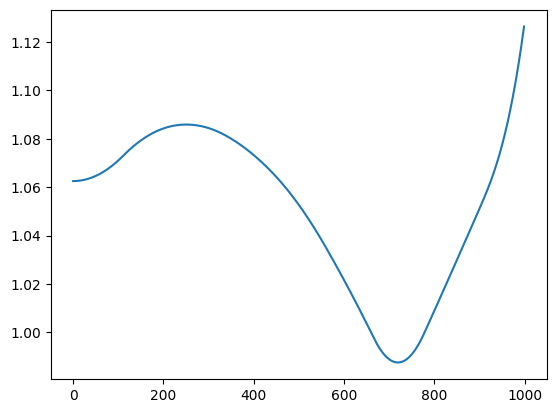

In [2]:
### Real Time Simulation ###
sim_time = tf+3
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(0.1)
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
graph = (pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())
with open('graph.svg', 'wb') as f:
    f.write(graph)

timesteps = np.linspace(0, tf, 1000)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = np.linalg.norm(u_traj.vector_values([t]))
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos)

np.save('com.npy', np.array(com_pos_list))
plt.plot(np.array(com_pos_list)[:,2])


In [3]:
### Go ###
sim_time = tf+2
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(1.5)
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
plant.SetPositionsAndVelocities(plant_context, initial_state)
simulator.AdvanceTo(sim_time)

AttributeError: module 'numpy.linalg' has no attribute 'rank'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[:,1:]

COM_POS, COM_VEL, T_POS, T_VEL, left, right, COM_POS_DESIRED, COM_VEL_DESIRED, Torso_POS_DESIRED, Torso_VEL_DESIRED, Ft_POS_DESIRED, Ft_POS_DESIRED =  OSC_Accesor.logParse(x)

# Function to create subplots for 3D data
def plot_3d_data(ax, data, label, linestyle='-'):
    ax.plot(data[0, :], label=f'{label} - X', linestyle=linestyle)
    ax.plot(data[1, :], label=f'{label} - Y', linestyle=linestyle)
    ax.plot(data[2, :], label=f'{label} - Z', linestyle=linestyle)

# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 20))

# Plotting each pair of actual and desired values
plot_3d_data(axs[0], COM_POS, 'COM_POS')
plot_3d_data(axs[0], COM_POS_DESIRED, 'COM_POS_DESIRED', '--')
axs[0].set_title('Center of Mass Position')
axs[0].legend()

plot_3d_data(axs[1], COM_VEL, 'COM_POS')
plot_3d_data(axs[1], COM_VEL_DESIRED, 'COM_POS_DESIRED', '--')
axs[1].set_title('Center of Mass Velocity')
axs[1].legend()

axs[2].plot(T_POS[0], label = 'T_POS')
axs[2].plot(Torso_POS_DESIRED[0], label='Torso_POS_DESIRED', linestyle='--')
axs[2].set_title('Torso Position')
axs[2].legend()

axs[3].plot(T_VEL[0], label='T_VEL')
axs[3].plot(Torso_VEL_DESIRED[0], label='Torso_VEL_DESIRED', linestyle='--')
axs[3].set_title('Torso Velocity')
axs[3].legend()

plot_3d_data(axs[4], left, 'Left')
# plot_3d_data(axs[4], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[4].set_title('Left and Desired Foot Position')
axs[4].legend()

plot_3d_data(axs[5], right, 'Right')
# plot_3d_data(axs[5], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[5].set_title('Right and Desired Foot Position')
axs[5].legend()

plt.tight_layout()
plt.show()
